In [191]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

In [192]:
targets = []
featuring = []
#Par rapport au Lung_n de cancer
files = glob.glob("lung/*.*")
random.shuffle(files)

In [193]:
for file in files[:1000]:
    featuring.append(np.array(Image.open(file).resize((75,75))))
    target = [1, 0] if "aca" in file else [0,1]     
   
#    if "aca" in file:
#        target = [0,1,2]
#    elif "n" in file:
#        target=[1,0,2]
#    else:
#        [2,0,1]
        
    targets.append(target)

featuring = np.array(featuring)
targets = np.array(targets)
    

In [194]:
targets

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [195]:
print(featuring.shape)

(1000, 75, 75, 3)


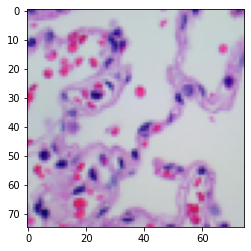

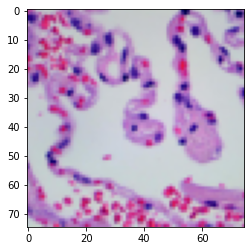

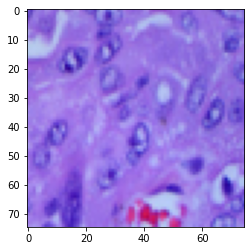

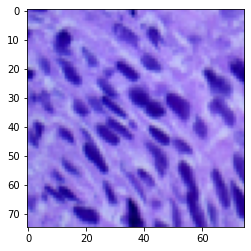

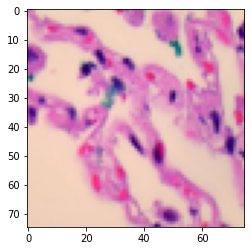

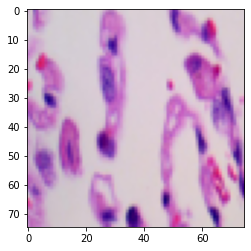

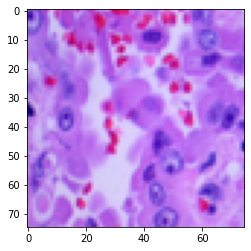

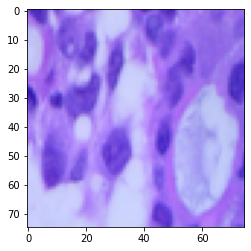

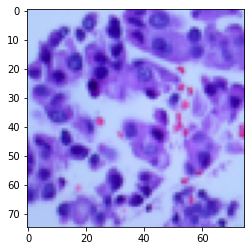

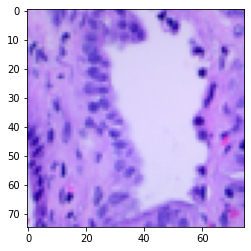

In [196]:
from random import randint

for a in [randint(0, len(targets)) for _ in range(10)]:
    plt.imshow(featuring[a])
    plt.show()
    


In [197]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid= train_test_split(featuring, targets, test_size = 0.1,random_state=42)
print("x_train :",x_train.shape)
print("x_valid :",x_valid.shape)
print("y_train :",y_train.shape)
print("y_valid :",y_valid.shape)


x_train : (900, 75, 75, 3)
x_valid : (100, 75, 75, 3)
y_train : (900, 2)
y_valid : (100, 2)


In [198]:
import tensorflow.compat.v1 as tf
#from tensorflow.contrb.layers import flatten
#import tensorflow.compat.v1.layers.flatten
tf.compat.v1.disable_eager_execution()
#placeholder
x = tf.compat.v1.placeholder(tf.float32, (None, 75,75, 3), name="Image")
y = tf.compat.v1.placeholder(tf.float32, (None,2), name="Targets") #(None,2)

def create_conv(prev, filter_size, nb):
    w_filters = tf.Variable(tf.truncated_normal(shape= (filter_size, filter_size, int(prev.get_shape()[-1]),nb)))
    b_filters = tf.Variable(tf.zeros(shape= (nb)))
    conv = tf.nn.conv2d(prev,w_filters, strides =[1,1,1,1], padding = "SAME") + b_filters
    conv = tf.nn.relu(conv)
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides = [1,2,2,1],padding = "SAME")
    return conv 

# Hyper paramètre
conv = create_conv(x,8,32)
conv = create_conv(conv,5,64)
conv = create_conv(conv,5,64)
conv = create_conv(conv,5,128)
conv = create_conv(conv,5,256)

flat = tf.compat.v1.layers.flatten(conv) #applatissement de l'image 

#fully connected layer

w1 = tf.Variable(tf.truncated_normal(shape= (flat.get_shape()[1], 521)))
b1 = tf.Variable(tf.zeros(shape= (521)))
fc1 = tf.matmul(flat, w1) + b1
fc1 = tf.nn.relu(fc1)

#fully connected layer (output)

w2 = tf.Variable(tf.truncated_normal(shape= (521, 2)))
b2 = tf.Variable(tf.zeros(shape= (2)))
logits = tf.matmul(fc1, w2) + b2
softmax = tf.nn.softmax(logits)

print(conv)

Tensor("MaxPool_94:0", shape=(None, 3, 3, 256), dtype=float32)


In [199]:
#Erreur et optimisation

#loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
#accuracy
correct_prediction = tf.equal(tf.argmax(softmax, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#Optimizier
optimizer = tf.train.AdamOptimizer(0.001)
train_op = optimizer.minimize(loss_operation)

In [200]:
#Train Model

batch_size = 300
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [201]:
for epoch in range(0, 10):
    index = np.arange(len(x_train))
    np.random.shuffle(index)
    x_train = x_train[index]
    y_train = y_train[index]
    
    for b in range(0,len(x_train), batch_size):
        print("b= %s, %s" % (b,len(x_train)))
        batch = x_train[ b: b + batch_size]
        sess.run(train_op, feed_dict = {x:batch, y: y_train[b:b+batch_size]})

    accs = []

    for b in range(0, len(x_valid), batch_size):
        batch = x_valid[ b: b + batch_size]
        acc = sess.run(accuracy, feed_dict = {x: batch, y: y_valid[b: b + batch_size]})
        accs.append(acc)

    print("mean Validation", np.mean(accs))

b= 0, 900
b= 300, 900
b= 600, 900
mean Validation 0.68
b= 0, 900
b= 300, 900
b= 600, 900
mean Validation 0.68
b= 0, 900
b= 300, 900
b= 600, 900
mean Validation 0.32
b= 0, 900
b= 300, 900
b= 600, 900
mean Validation 0.68
b= 0, 900
b= 300, 900
b= 600, 900
mean Validation 0.68
b= 0, 900
b= 300, 900
b= 600, 900
mean Validation 0.65
b= 0, 900
b= 300, 900
b= 600, 900
mean Validation 0.74
b= 0, 900
b= 300, 900
b= 600, 900
mean Validation 0.7
b= 0, 900
b= 300, 900
b= 600, 900
mean Validation 0.64
b= 0, 900
b= 300, 900
b= 600, 900
mean Validation 0.75


In [202]:
np.mean(accs)

0.75

In [203]:
if np.mean(accs) > 0.5:
    print(" c'est un n")
else:
    print("C'est une autre chose ")

 c'est un n


In [204]:
# on veut tester !!
files2 = glob.glob("lung_scc/*.*")